In [16]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [15]:
# Follow: https://kikaben.com/gangenerative-adversarial-network-simple-implementation-with-pytorch/

transform = transforms.ToTensor()
dataset = datasets.MNIST(
    root = './data', 
    train = True, # training set  
    download = True, 
    transform = transform 
)
dataloader = DataLoader(
    dataset, 
    batch_size = 64, 
    drop_last = True # Discard the last non divisible batch 
)

images, labels = next(iter(dataloader))

print(images.shape)
print(labels)
# Tensor[64, 1, 28, 28] -> 64 = Batch size. 1 = Color channel. 28x28 image. 

torch.Size([64, 1, 28, 28])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])


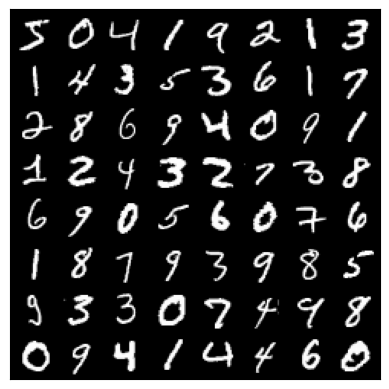

In [19]:
def show_image_grid(images: torch.Tensor, ncol: int): 
    image_grid = make_grid(
        images, 
        ncol
    ) # Make images into a grid 

    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last 
    image_grid = image_grid.cpu().numpy() 

    plt.imshow(image_grid)
    plt.xticks([]) # Empty x and y labels 
    plt.yticks([])
    plt.show() 


show_image_grid(
    images = images, 
    ncol = 8
)

In [22]:
# Generator. 
# Random value vector as input i.e. random values into image
# Standard normal diitribution as init
z = torch.randn(1, 100)
print(z)

tensor([[ 0.3789, -0.4149,  0.2260,  1.4155, -1.0605,  0.2137,  0.3217,  1.3318,
         -1.6761, -1.7879,  1.7455,  0.4514, -0.2086,  0.4763,  1.2561,  2.1511,
         -0.4545, -0.5610,  0.0567, -0.3668, -0.6362,  0.0148, -0.4692,  0.7751,
          0.0660,  1.2006, -1.7691,  0.1223, -0.8530, -0.3111,  2.2510,  0.6299,
          1.7997,  1.1745, -0.2530,  1.5454,  0.7815, -0.1416,  0.4324, -0.0696,
          0.4775,  0.4630,  0.7556, -0.1062,  0.8109,  1.0910, -0.7388, -0.9688,
         -0.5894, -1.2678, -0.9305,  0.6279, -0.1076,  0.6871, -1.1329, -1.5458,
          0.5684, -0.3968, -0.3958, -0.9607, -0.0605,  0.0885, -0.0831,  0.8199,
         -1.9815, -1.4377, -0.1311,  1.1461, -0.1657,  1.0841, -0.8769, -1.1854,
         -0.6158,  0.8852,  1.7969, -1.1400,  0.2188, -1.8407,  0.3649, -1.3872,
          1.9373, -0.1283, -0.2603, -1.5180,  0.7789, -2.7428,  1.4924, -1.3136,
          0.0852, -1.2948,  1.3665,  0.0498, -0.8243, -0.1132,  0.6019, -0.6227,
          1.0907,  0.1456,  

In [23]:
generator = nn.Sequential(
    nn.Linear(
        in_features = 100,
        out_features = 128
    ),
    nn.LeakyReLU(0.01),
    nn.Linear(
        in_features = 128,
        out_features = 784 # 784 = 28x28 image 
    ),
    nn.Sigmoid() # Squeeze the ouput values between 0 and 1 i.e. grayscale.
)

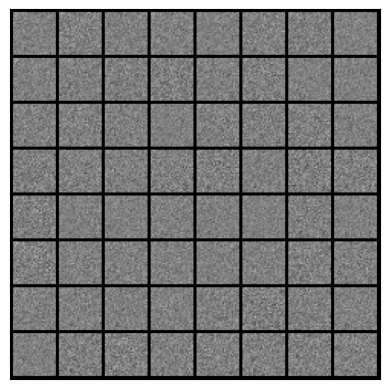

In [28]:
def generate_images():
    z = torch.randn(64, 100)
    output = generator(z)
    # Reshape the output to 64 images 
    generated_images = output.reshape(64, 1, 28 ,28)
    return generated_images

generated_images = generate_images()
show_image_grid(
    generated_images, 
    ncol = 8
)

# Output should be random noise since the generator has not been trained.

In [ ]:
# Discriminator: Real or Fake
# Fake = Does not look like it is from MNIST 
# Real = Looks like it is from MNIST
